In [1]:
#!pip install pyLDAvis

In [11]:
import pandas as pd
import re
import os
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [12]:
base_directory = "C:/Users/jonat/Documents/github/job-posting-analysis"


directory = os.chdir(f"{base_directory}/data/cleaned/")
files = os.listdir(".")
files


monster_df = pd.read_csv('All_MonsterSg.csv') 
monster_df.head(3)

job_title               company  \
0                         Senior Python Developer                  Citi   
1  Senior Partner Solutions Architect (Microsoft)                Amazon   
2                                   IT Technician  Ascend Com Pte. Ltd.   

               salary   job_type years_experience  \
0                 NaN  permanent              NaN   
1                 NaN  permanent              NaN   
2  ['24000', '36000']  permanent       ['2', '5']   

                                          tech_stack  \
0                                                NaN   
1                                                NaN   
2  ['Switches', 'Mac', 'Windows 10', 'Cloud Compu...   

                                     job_description  \
0  Job Description :\r\n\r\nJob Purpose:\r\nWe ar...   
1  Job Description :\r\nJob summary\r\nDESCRIPTIO...   
2  Responsibilities:\r\nProvide helpdesk support ...   

                                    industry function  \
0  ['Banking/Accounting/Financial Services']   ['IT']   
1                    ['Internet/E-commerce']   ['IT']   
2                                  ['Other']   ['IT']   

                              roles date_posted  \
0  ['Software Engineer/Programmer']  2022-02-18   
1  ['Software Engineer/Programmer']  2022-02-18   
2   ['Other Software/Hardware/EDP']  2022-02-19   

                                                 url  
0  https://www.monster.com.sg/seeker/job-details?...  
1  https://www.monster.com.sg/seeker/job-details?...  
2  https://www.monster.com.sg/seeker/job-details?...

In [13]:
monster_df.job_description[0]

"Job Description :\r\n\r\nJob Purpose:\r\nWe are looking for a Skilled Python Developer who can design and build best-in-class data driven applications for front office teams across the global markets business. You will work closely with product owners, project managers, developers, data scientists and other team members to deliver solutions through new and existing channels. You will need to be confident to work with senior business stakeholders to understand their requirements and to ideate and drive the development of innovative technology solutions in a timely manner.\r\n\r\nJob Background/context:\r\nWe believe the future is here with us! Home to where we define, ideate, develop and distribute production-ready financial solutions of far-reaching impact. And right now, the door is open to help develop the future of our technology for a truly global client base. This means collaborating with the keenest minds in data science, big data, software engineering, web development, UX desig

In [14]:
re.sub('\n', "", '\r\n\r\nJob Purpose:\r\nWe are looking f')

'\r\rJob Purpose:\rWe are looking f'

In [15]:
re.sub('\r','','\r\nJob Purpose:\r\nWe are looking f')

'\nJob Purpose:\nWe are looking f'

In [16]:
import re
x = '\r\n\r\nJob Purpose:\r\nWe are -------------------!!@#!!--------------looking f??'
x= x.replace("\r", "")
x = x.replace ("\n", "")
x = x.replace("-", "")

x =re.sub(r'[^\w\s]', '', x)

x

'Job PurposeWe are looking f'

In [17]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [48]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['u','ubs','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

def clean_job_description(x):

    x = re.sub(r'\w*\d\w*','', str(x))
    x = x.replace("\r", " ")
    x = x.replace ("\n", " ")
    x = re.sub(r'[^\w\s]', '', x)
    x = x.lower()
    x = x.split(' ')
    return x

def remove_stop_words(x,stop_words):
    cleaned_list = []
    for i in x: 
        if i != "" and i not in stop_words:
            cleaned_list.append(lemmatizer.lemmatize(i))
    
    return cleaned_list

In [49]:
monster_job_description = monster_df['job_description']
monster_job_description = monster_job_description.apply(lambda x: clean_job_description(x))
monster_job_description = monster_job_description.apply(lambda x: remove_stop_words(x,stop_words))
monster_job_description.tail(10)
# monster_job_description = monster_job_description.to_frame(name='job_description')
# monster_job_description

8405    [job, description, support, marketing, manager...
8406    [job, responsibility, demonstrate, knowledge, ...
8407    [android, java, kotlin, spring, boot, mysql, d...
8408    [business, used, rely, technology, business, t...
8409    [toff, technology, toff, provide, solution, de...
8410    [job, description, responsible, overall, platf...
8411    [job, description, senior, developer, primary,...
8412    [location, paya, lebar, working, hour, shift, ...
8413    [director, responsible, managing, large, compl...
8414    [company, client, market, leader, within, indu...
Name: job_description, dtype: object

In [50]:
monster_job_description.tolist()

[['job',
  'description',
  'job',
  'purpose',
  'looking',
  'skilled',
  'python',
  'developer',
  'design',
  'build',
  'bestinclass',
  'data',
  'driven',
  'application',
  'front',
  'office',
  'team',
  'across',
  'global',
  'market',
  'business',
  'work',
  'closely',
  'product',
  'owner',
  'project',
  'manager',
  'developer',
  'data',
  'scientist',
  'team',
  'member',
  'deliver',
  'solution',
  'new',
  'existing',
  'channel',
  'confident',
  'work',
  'senior',
  'business',
  'stakeholder',
  'understand',
  'requirement',
  'ideate',
  'drive',
  'development',
  'innovative',
  'technology',
  'solution',
  'timely',
  'manner',
  'job',
  'backgroundcontext',
  'believe',
  'future',
  'u',
  'home',
  'define',
  'ideate',
  'develop',
  'distribute',
  'productionready',
  'financial',
  'solution',
  'farreaching',
  'impact',
  'door',
  'open',
  'help',
  'develop',
  'future',
  'technology',
  'truly',
  'global',
  'client',
  'base',
  'mea

## Create Corpus

In [51]:
def str_to_list(text):
    text = text[1:len(text)-1]
    #text_list = text.split(',')
    text_list = [text.strip()[1:-1] for text in text]
    return text_list

In [52]:
data_lemmatized = monster_job_description.tolist()
#data_lemmatized = [str_to_list(text) for text in data_lemmatized]
print(data_lemmatized[:10])

[['job', 'description', 'job', 'purpose', 'looking', 'skilled', 'python', 'developer', 'design', 'build', 'bestinclass', 'data', 'driven', 'application', 'front', 'office', 'team', 'across', 'global', 'market', 'business', 'work', 'closely', 'product', 'owner', 'project', 'manager', 'developer', 'data', 'scientist', 'team', 'member', 'deliver', 'solution', 'new', 'existing', 'channel', 'confident', 'work', 'senior', 'business', 'stakeholder', 'understand', 'requirement', 'ideate', 'drive', 'development', 'innovative', 'technology', 'solution', 'timely', 'manner', 'job', 'backgroundcontext', 'believe', 'future', 'u', 'home', 'define', 'ideate', 'develop', 'distribute', 'productionready', 'financial', 'solution', 'farreaching', 'impact', 'door', 'open', 'help', 'develop', 'future', 'technology', 'truly', 'global', 'client', 'base', 'mean', 'collaborating', 'keenest', 'mind', 'data', 'science', 'big', 'data', 'software', 'engineering', 'web', 'development', 'ux', 'design', 'doer', 'lookin

In [53]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=5, no_above=0.85)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [54]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'able'), (1, 'accommodation'), (2, 'achieve'), (3, 'across'), (4, 'action'), (5, 'affirmative'), (6, 'agile'), (7, 'ahead'), (8, 'alone'), (9, 'analytics'), (10, 'andor'), (11, 'angular'), (12, 'ant'), (13, 'anywhere'), (14, 'apac'), (15, 'applicant'), (16, 'application'), (17, 'apply'), (18, 'architecture'), (19, 'array'), (20, 'associated'), (21, 'aws'), (22, 'backgroundcontext'), (23, 'base'), (24, 'based'), (25, 'believe'), (26, 'best'), (27, 'bestinclass'), (28, 'bi'), (29, 'big'), (30, 'bold'), (31, 'boot'), (32, 'bring'), (33, 'broad'), (34, 'broader'), (35, 'build'), (36, 'business'), (37, 'caching'), (38, 'capability'), (39, 'capable'), (40, 'career'), (41, 'cd'), (42, 'centric'), (43, 'change'), (44, 'channel'), (45, 'ci'), (46, 'citi'), (47, 'citigroup'), (48, 'clear'), (49, 'client')]

Total Vocabulary Size: 11013


## Building LDA Model

### Hypertuning Model Parameters

In [55]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [56]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.33396772711904077
Perplexity Score:  -7.247508976631015

topic number:  3
Coherence Score:  0.3330615082581423
Perplexity Score:  -7.20334544880702

topic number:  4
Coherence Score:  0.34179991819229705
Perplexity Score:  -7.173691185566666

topic number:  5
Coherence Score:  0.34248224875211164
Perplexity Score:  -7.152916919422434

topic number:  6
Coherence Score:  0.33609574519534186
Perplexity Score:  -7.135231581748814

topic number:  7
Coherence Score:  0.34819760396892147
Perplexity Score:  -7.125261219825447

topic number:  8
Coherence Score:  0.3552485226372574
Perplexity Score:  -7.119397848032497

topic number:  9
Coherence Score:  0.3669497101273549
Perplexity Score:  -7.121477462209499

topic number:  10
Coherence Score:  0.38647147929696013
Perplexity Score:  -7.141473497486847

topic number:  11
Coherence Score:  0.3871286516276419
Perplexity Score:  -7.1708691389424

topic number:  12
Coherence Score:  0.38578342086745193
Perplexit

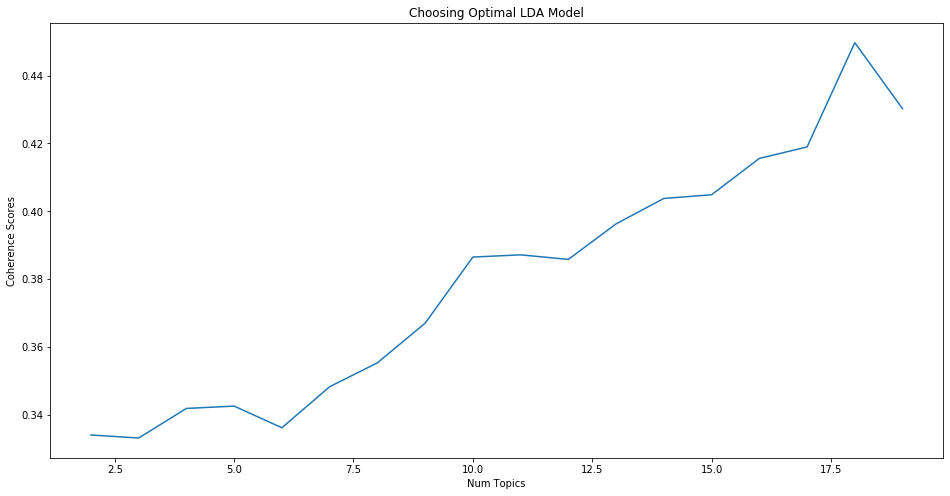

In [57]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [58]:
ntopics = 14

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [59]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.048*"customer" + 0.033*"sale" + 0.017*"business" + 0.014*"account" + '
  '0.013*"solution" + 0.012*"team" + 0.010*"opportunity" + 0.009*"product" + '
  '0.008*"work" + 0.007*"vmware"'),
 (1,
  '0.013*"development" + 0.013*"singapore" + 0.012*"data" + 0.010*"product" + '
  '0.009*"system" + 0.008*"technology" + 0.008*"solution" + 0.007*"test" + '
  '0.007*"grab" + 0.007*"customer"'),
 (2,
  '0.024*"development" + 0.019*"design" + 0.019*"application" + '
  '0.019*"software" + 0.013*"knowledge" + 0.011*"technology" + 0.009*"team" + '
  '0.009*"skill" + 0.009*"code" + 0.009*"web"'),
 (3,
  '0.022*"aws" + 0.020*"team" + 0.015*"amazon" + 0.014*"business" + '
  '0.012*"customer" + 0.010*"work" + 0.008*"qualification" + 0.008*"service" + '
  '0.007*"balance" + 0.007*"member"'),
 (4,
  '0.012*"team" + 0.011*"work" + 0.011*"technology" + 0.009*"status" + '
  '0.009*"service" + 0.008*"opportunity" + 0.008*"global" + 0.008*"financial" '
  '+ 0.007*"u" + 0.006*"requirement"'),
 (5,
  '0.0

In [60]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [61]:
topic_num = []
print(lda_model.get_document_topics(corpus))
for n in range(len(monster_df)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])

In [62]:
monster_df['Topic'] = topic_num

In [63]:
monster_df

job_title  \
0                               Senior Python Developer   
1        Senior Partner Solutions Architect (Microsoft)   
2                                         IT Technician   
3                                     Customer Engineer   
4                                     Customer Engineer   
...                                                 ...   
8410             Application Architect (Classification)   
8411                                   Senior Developer   
8412  Customer Service Exec (East, up to $2500, Gd b...   
8413                          Director, Virtual Banking   
8414  Senior IT Manager (Oracle) / Senior Manager, I...   

                                          company                salary  \
0                                            Citi                   NaN   
1                                          Amazon                   NaN   
2                            Ascend Com Pte. Ltd.    ['24000', '36000']   
3     Applied Materials South East Asia Pte. Ltd.    ['42000', '84000']   
4     Applied Materials South East Asia Pte. Ltd.    ['46800', '93600']   
...                                           ...                   ...   
8410                           Combuilder Pte Ltd  ['108000', '156000']   
8411                    Vault Personnel Pte. Ltd.    ['66000', '78000']   
8412                   People Profilers Pte. Ltd.    ['26400', '30000']   
8413                 Synpulse Singapore Pte. Ltd.  ['120000', '240000']   
8414                        Randstad Pte. Limited  ['120000', '168000']   

       job_type years_experience  \
0     permanent              NaN   
1     permanent              NaN   
2     permanent       ['2', '5']   
3     permanent       ['2', '5']   
4     permanent       ['2', '5']   
...         ...              ...   
8410  permanent     ['10', '15']   
8411  permanent       ['2', '5']   
8412  permanent       ['0', '2']   
8413  permanent      ['7', '10']   
8414  permanent     ['10', '15']   

                                             tech_stack  \
0                                                   NaN   
1                                                   NaN   
2     ['Switches', 'Mac', 'Windows 10', 'Cloud Compu...   
3     ['Scalability', 'Cloud Computing', 'Google Clo...   
4     ['Scalability', 'Cloud Computing', 'Google Clo...   
...                                                 ...   
8410  ['Pyspark', 'Scalability', 'Application Develo...   
8411  ['Css3', 'Php', '.NET', 'Application Developme...   
8412  ['Windows', 'Customer Service Skills', 'Custom...   
8413  ['Wealth Management', 'Mentoring', 'Quality Co...   
8414  ['Oracle', 'Erp', 'Application Development', '...   

                                        job_description  \
0     Job Description :\r\n\r\nJob Purpose:\r\nWe ar...   
1     Job Description :\r\nJob summary\r\nDESCRIPTIO...   
2     Responsibilities:\r\nProvide helpdesk support ...   
3     Key Responsibilities\r\nPerforms all standard ...   
4     Has developed specialized skills or is multi-s...   
...                                                 ...   
8410  Job Description:\r\nResponsible for overall pl...   
8411  Job Description:\r\nThe Senior Developer, IT p...   
8412  Location: Paya Lebar\r\nWorking hours: 10am 11...   
8413  As a Director, you will be responsible for man...   
8414  About the company\r\nOur Client is a market le...   

                                       industry  \
0     ['Banking/Accounting/Financial Services']   
1                       ['Internet/E-commerce']   
2                                     ['Other']   
3                                     ['Other']   
4                                     ['Other']   
...                                         ...   
8410                                  ['Other']   
8411                                  ['Other']   
8412                                  ['Other']   
8413                                  ['Other']   
8414                    

## Visualisation

In [64]:
import pyLDAvis.gensim_models as gensimvis

In [65]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.004227 -0.030598       1        1  16.049086
5     -0.144547  0.052514       2        1  11.510127
2     -0.199046 -0.015079       3        1  10.132215
12     0.120983  0.065288       4        1   8.167738
8     -0.031880 -0.145198       5        1   7.629006
6     -0.193907 -0.016733       6        1   7.500713
13     0.126327 -0.121943       7        1   7.421742
0      0.140984 -0.048054       8        1   6.544612
4      0.083412  0.116649       9        1   5.747431
10    -0.133004 -0.037697      10        1   5.449157
3      0.115012 -0.071130      11        1   4.253744
7      0.039846 -0.024817      12        1   3.653800
1     -0.055409  0.168711      13        1   3.507100
11     0.135456  0.108089      14        1   2.433528, topic_info=         Term          Freq         Total Category  logprob  loglift
68       data  17542.000000  17542.000000  Default  30.0000  30.0000
344  customer  20475.000000  20475.000000  Default  29.0000  29.0000
415      sale   8759.000000   8759.000000  Default  28.0000  28.0000
416  security  11691.000000  11691.000000  Default  27.0000  27.0000
21        aws  10295.000000  10295.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
36   business    502.788318  24121.723999  Topic14  -4.7546  -0.1549
324      area    347.235238   2785.524368  Topic14  -5.1248   1.6336
123    global    371.303799   5484.847875  Topic14  -5.0578   1.0231
132      help    364.726707   5666.886739  Topic14  -5.0756   0.9726
3      across    358.832791   6844.481698  Topic14  -5.0919   0.7675

[1230 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2060      1  0.981002     abap
489       1  0.282243  ability
489       2  0.068804  ability
489       3  0.066267  ability
489       4  0.012102  ability
...     ...       ...      ...
2231      4  0.992670  zendesk
4300      2  0.120031     zoom
4300      8  0.865935     zoom
4300     10  0.008574     zoom
5435     11  0.994394      zos

[4301 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 3, 13, 9, 7, 14, 1, 5, 11, 4, 8, 2, 12])

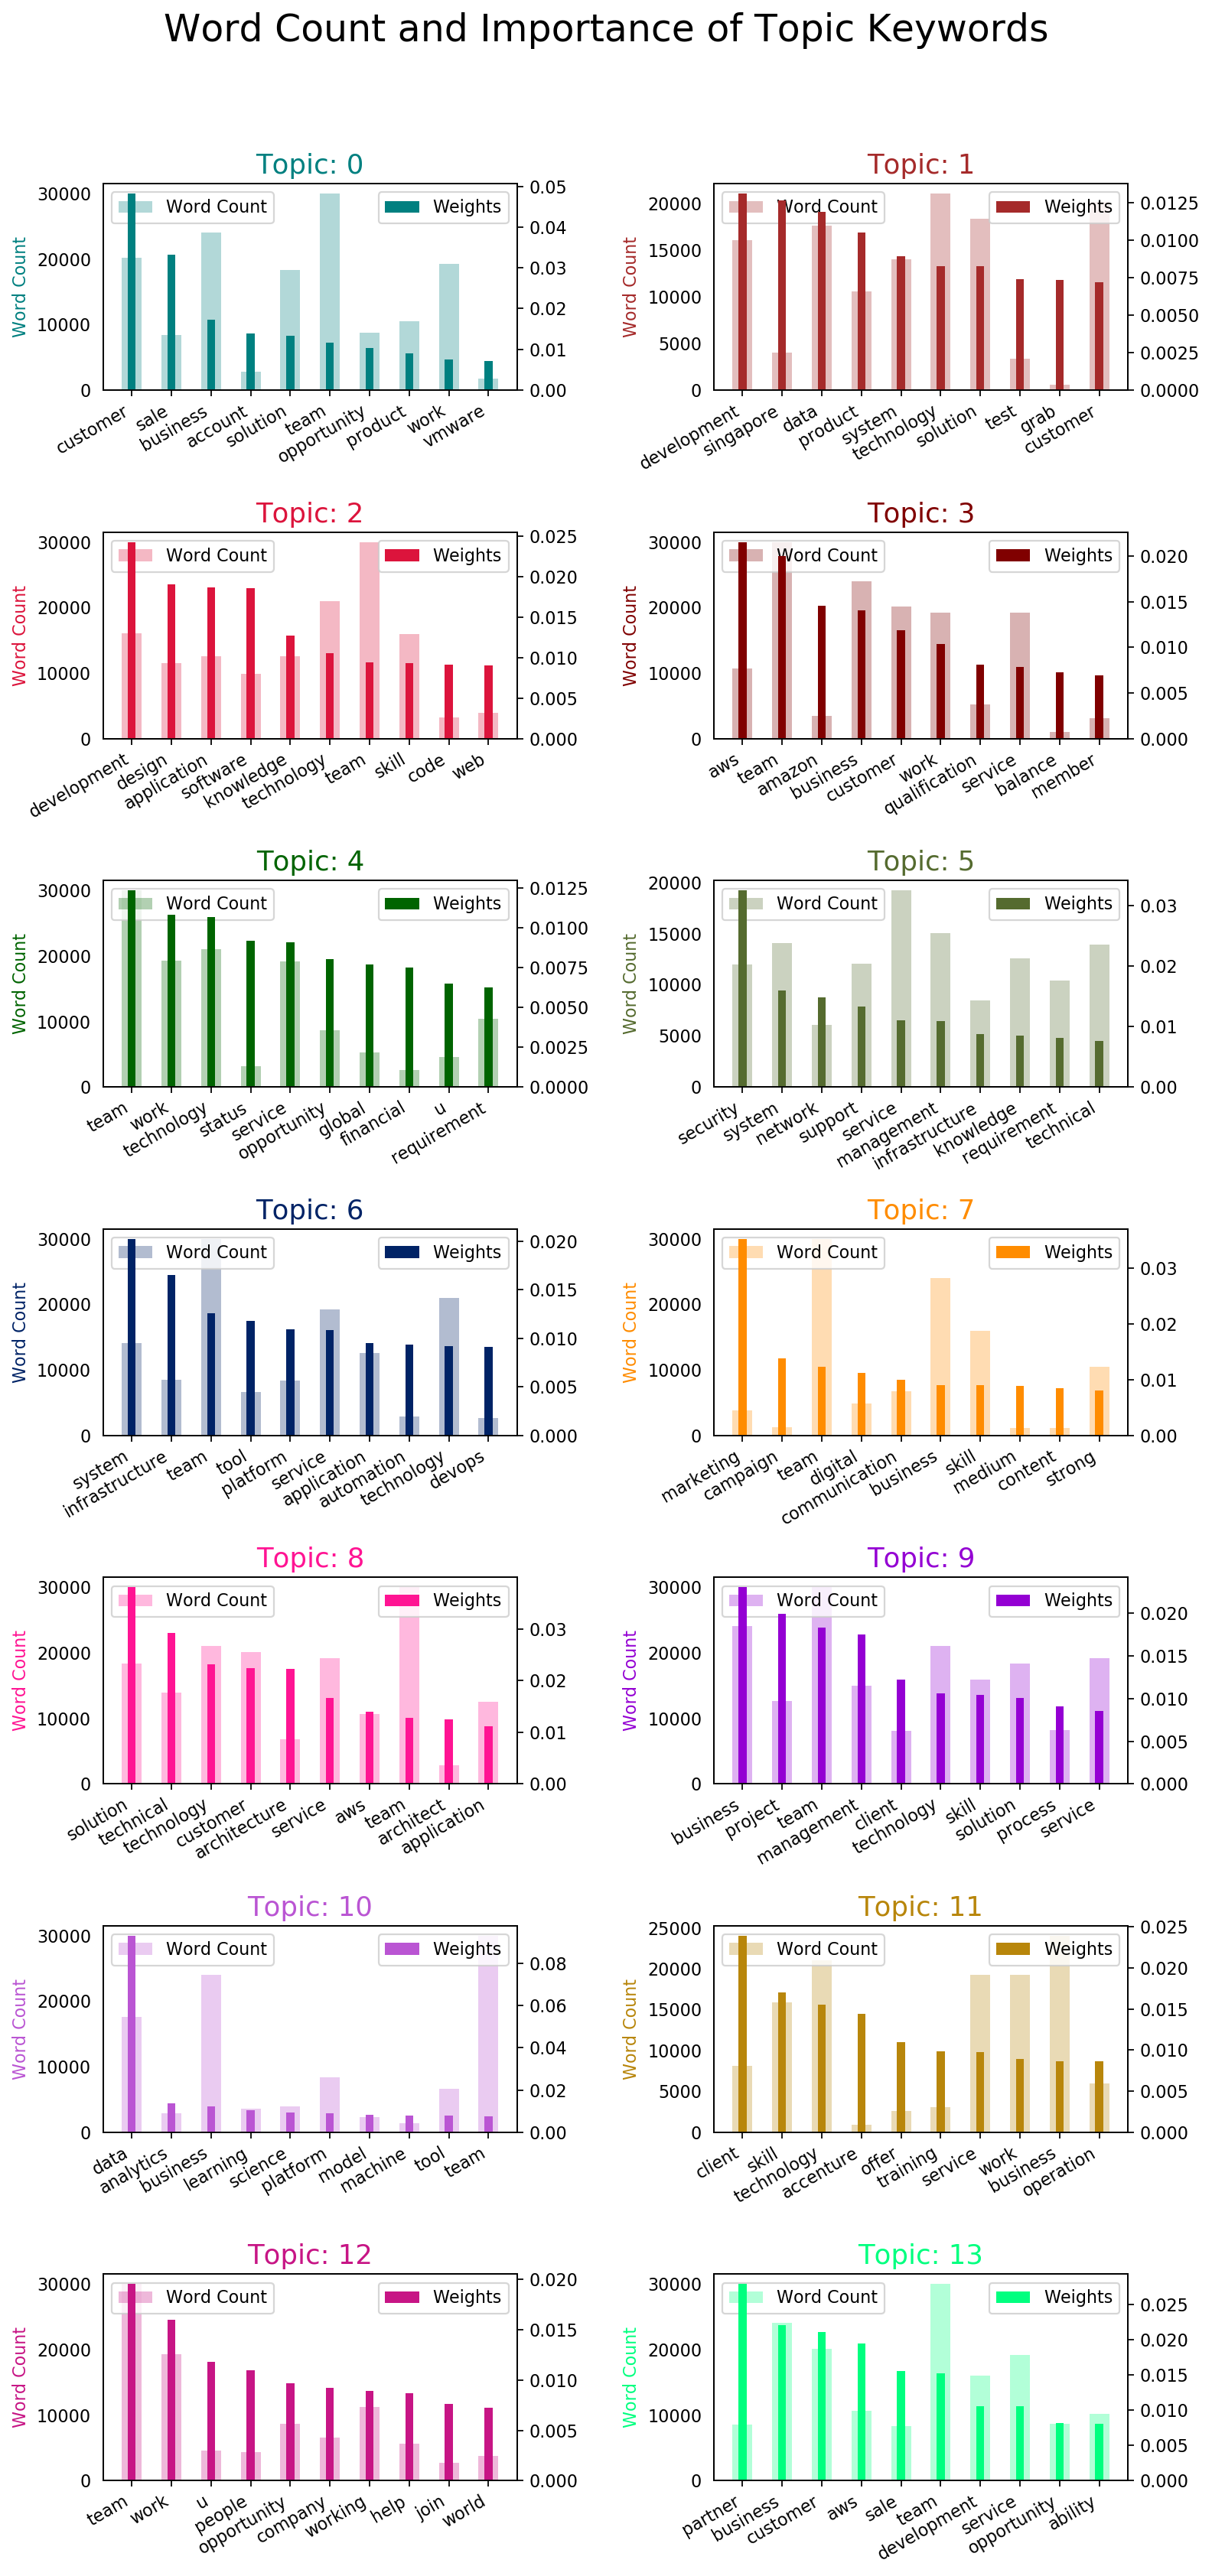

In [67]:
from collections import Counter

topics = lda_model.show_topics(num_topics=15, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(7, 2, figsize=(10,20), dpi=160)
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()